In [1]:
library(Seurat)
library(patchwork)
library(tidyverse)
library(ggpubr)
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")

source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/cellcycle_ana.R")
library(foreach)
library(doParallel)

library(ComplexHeatmap)
library(circlize)

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

circlize version 0.4.13
CRAN page: https://c

In [2]:
hires <- readRDS("../../hires_mouse_emb_dev.new.rds")
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

In [3]:
hires[[]] %>% select(pairs_dedup, pairs_clean3,pairs_clean2) %>% mutate(diffr = (pairs_clean2 - pairs_clean3) / pairs_dedup) %>% summary()

  pairs_dedup      pairs_clean3     pairs_clean2        diffr          
 Min.   : 58911   Min.   : 49998   Min.   : 50031   Min.   :0.0001066  
 1st Qu.:237828   1st Qu.:205354   1st Qu.:205451   1st Qu.:0.0003507  
 Median :306194   Median :267633   Median :267788   Median :0.0004000  
 Mean   :317482   Mean   :277542   Mean   :277671   Mean   :0.0004109  
 3rd Qu.:385013   3rd Qu.:339799   3rd Qu.:339940   3rd Qu.:0.0004596  
 Max.   :918770   Max.   :828179   Max.   :828545   Max.   :0.0008785  

In [3]:
# load data
di_all <- read_tsv("../../figure3_related_new/di_emb_nonp/alldis.tsv.gz")

Rows: 5689793 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
set.seed(42)
bin_annotation <- di_all %>% filter(diff < 0) %>% arrange(FDR) %>% group_by(pos) %>% mutate(count = n()) %>%
    filter(count == 1) %>% group_by(celltype) %>% arrange(FDR) %>% 
  filter(FDR < quantile(FDR, 0.05)) %>% ungroup() %>% sample_n(10000)

In [ ]:
chrom_mat_list_all <- list()
for (c in seq(1:19)){
    print(paste0("Chromosome ",c," processing!"))
    flush.console() 
    chrom_temp <- readRDS(paste0("../../figure3_related_new/di_emb_nonp/di_mat/chr",as.character(c),".mat.rds.gz"))
    names_temp <- intersect(names(chrom_temp),bin_annotation %>% pull(pos))
    chrom_mat_list_all[[c]] <- chrom_temp[,names_temp]
    print(paste0("Chromosome ",c," done!"))
    flush.console()
}
mat_all <- chrom_mat_list_all[[1]]
for (i in seq(1,19)){
    mat_all <- cbind(mat_all,chrom_mat_list_all[[i]])
}

[1] "Chromosome 1 processing!"
[1] "Chromosome 1 done!"
[1] "Chromosome 2 processing!"
[1] "Chromosome 2 done!"
[1] "Chromosome 3 processing!"
[1] "Chromosome 3 done!"
[1] "Chromosome 4 processing!"
[1] "Chromosome 4 done!"
[1] "Chromosome 5 processing!"
[1] "Chromosome 5 done!"
[1] "Chromosome 6 processing!"


In [ ]:
# Fig 3 B

# we only randomly sampled 10000 celltype specific "negative" di(more interaction strength in given celltype) for plot
set.seed(42) 
#bin_annotation <- di_all_sample %>% filter(diff < 0) %>% arrange(FDR) %>% group_by(pos) %>% mutate(count = n()) %>% filter(count == 1)%>% ungroup() %>% select(celltype,pos) %>% sample_n(5000,replace=T) %>% arrange(celltype)
bins_select <- bin_annotation %>% pull(pos) %>% unique()
distance_on_di <- mat_all[,bins_select]
distance_on_di <- distance_on_di[c(TRUE,FALSE),] + distance_on_di[c(FALSE,TRUE),]
distance_on_di <- as.data.frame(distance_on_di)
rownames(distance_on_di) <- rownames(distance_on_di) %>% str_remove("mat")

set.seed(42)
celltype_order <-  names(celltypeColors)

celltype_consider <- bin_annotation%>% pull(celltype)%>% unique() %>% str_replace_all("_"," ")
celltype_annotation <- hires[[]] %>% select(celltype) %>% arrange(celltype) %>% filter(celltype %in% celltype_consider)
celltype_annotation$celltype <- factor(celltype_annotation$celltype,levels = celltype_order)
celltype_annotation <- celltype_annotation %>% arrange(celltype)

leftAnno <- rowAnnotation(df= celltype_annotation ,col = list(celltype=celltypeColors),show_legend = FALSE,show_annotation_name = FALSE)

bin_annotation <- bin_annotation %>% mutate(celltype = str_replace_all(celltype,pattern = "_",replacement = " " )) %>% column_to_rownames("pos")
bin_annotation$celltype <- factor(bin_annotation$celltype,levels = celltype_order)
bin_annotation <- bin_annotation %>% arrange(celltype)

topAnno <- columnAnnotation(df=bin_annotation,col = list(celltype=celltypeColors),show_legend = FALSE,show_annotation_name = FALSE)

plotmatrix <- distance_on_di[rownames(celltype_annotation),rownames(bin_annotation)] %>% as.matrix()

In [ ]:
summary_mat_data <- plotmatrix %>% as.data.frame() %>% rownames_to_column("cellname") %>% gather(bin,value,-cellname)
summary_mat_data <- summary_mat_data %>% left_join(bin_annotation %>% mutate(bin_celltype = celltype) %>% rownames_to_column("bin") %>% select(-celltype)) %>% 
                     left_join(celltype_annotation %>% mutate(cell_celltype = celltype) %>% rownames_to_column("cellname") %>% select(-celltype)) %>% 
    group_by(cell_celltype,bin)%>% summarise(value = mean(value,na.rm=T))

summary_mat_data <- summary_mat_data %>% left_join(bin_annotation %>% mutate(bin_celltype = celltype) %>% rownames_to_column("bin") %>% select(-celltype)) %>% 
                     left_join(celltype_annotation %>% mutate(cell_celltype = celltype) %>% rownames_to_column("cellname") %>% select(-celltype)) %>% 
    group_by(cell_celltype,bin)%>% summarise(value = mean(value,na.rm=T))
summary_mat_data <- summary_mat_data %>% spread(cell_celltype,value) %>% column_to_rownames("bin")%>% t() %>% scale(center = T,scale = F)

In [ ]:
summary_mat_data = - summary_mat_data

In [ ]:
topAnno <- columnAnnotation(df=bin_annotation %>% select(celltype),col = list(celltype=celltypeColors),show_legend = FALSE,show_annotation_name=FALSE)
#col_fun = colorRamp2(seq(from = -0.4,to=0.4,length.out = 8), rev(c("#fafb16","#E8C931","#96C761","#53C689","#12ACD6","#2C84F6","#453AD9","#3d28af")))
col_fun = colorRamp2(seq(-0.4,0.4,length.out = 3), rev(c("#00FF00","#c091a3","#e952f8")))
options(repr.plot.height = 4, repr.plot.width = 5,repr.plot.res = 200)

summary_mat_data[seq(17),rownames(bin_annotation)] %>% 
    Heatmap(cluster_columns = FALSE,cluster_rows = FALSE,show_column_names = FALSE,show_row_names = FALSE,col=col_fun,
        heatmap_legend_param = list(title = "Mean interactions(centered)",direction = "vertical"),
        top_annotation = topAnno,use_raster = TRUE
    ) -> summary_heatmap
draw(summary_heatmap,heatmap_legend_side="right")

In [12]:
pdf("di_heatmap.pdf",width = 6,height = 3,fonts = "Helvetica") 
# Code of the plot
draw(summary_heatmap,,heatmap_legend_side="right")
# Close the graphics device
dev.off() 

png 
  2

In [4]:
# 3C
mc_hires <- readRDS("../../figure3_related_new/di_emb_nonp/hires_emb_metacell.rds")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


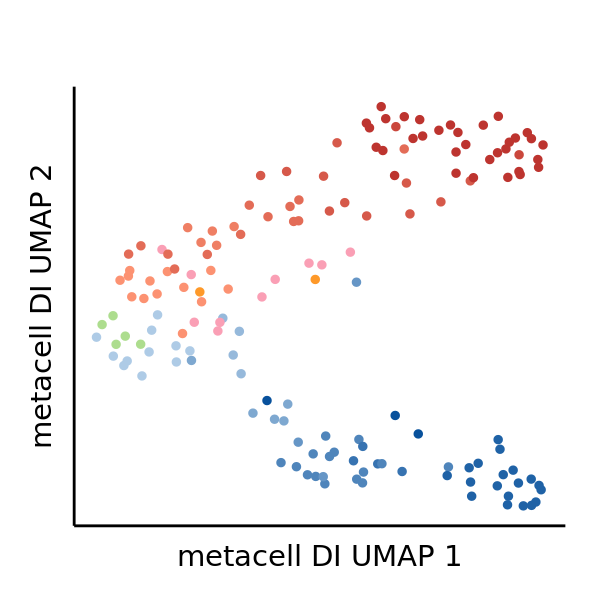

In [6]:
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
p <- DimPlot(mc_hires,group.by = "celltype",cols = celltypeColors,reduction = "mcdi_umap",label=F,pt.size = 0.4) + NoLegend() 
p <- p +theme_Publication() + NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("metacell DI UMAP 1") + ylab("metacell DI UMAP 2") + ggtitle("")
p
p %>% ggsave(filename = "umap_mcdi.pdf",height = 2, width =2,dpi=300,units ="in")

In [17]:
# example_plot

In [16]:
allgadi_bedpe <- read_tsv("../../figure3_related_new/di_emb_nonp/hires_emb_gadi.tsv.gz")
# allgadi %>% group_by(name,pos) %>% slice(1) %>% ungroup() -> allgadi
# allgadi <- allgadi %>% mutate(fdr_cor = p.adjust(pv,method="BH")) %>% filter(fdr_cor < 0.01)

# allgadi_bedpe <- allgadi %>%mutate(pos1=pos) %>% separate(pos1,into = c("chrom","bin1","bin2")) %>% mutate(bin1 = as.numeric(bin1),bin2 = as.numeric(bin2)) %>% 
#         mutate(start1=bin1 - 10000,start2=bin2-10000,end1 = bin1 + 10000,end2 = bin2+ 10000,chrom1 = chrom,chrom2 = chrom)%>% 
#         select(chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos)
# allgadi_bedpe <- allgadi_bedpe %>% group_by(name) %>% mutate(count = n()) %>% filter(count > 10) %>% ungroup() %>% select(-count) 

Rows: 390252 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chrom1, chrom2, name, pos, GADI_id
dbl (7): start1, end1, start2, end2, cor, pv, fdr_cor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
library(ggbio)
library(GenomicRanges)
options(bedtools.path = "~/miniconda3/envs/py3/bin")
library(bedtoolsr)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Need specific help about ggbio? try mailing 
 the maintainer or visit https://lawremi.github.io/ggbio/


Attaching package: 'ggbio'


The following objects are masked from 'package:ggplot2':

    geom_bar, geo

In [27]:
dcc_gadi <- allgadi_bedpe %>% filter(name =="Dcc") 
head(dcc_gadi)

chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos,GADI_id
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr18,70290000,70310000,chr18,70810000,70830000,Dcc,0.2427190,0.002120680924,0.00674473939,chr18-70300000-70820000,GADI_68997
chr18,70310000,70330000,chr18,70810000,70830000,Dcc,0.2325750,0.003275324336,0.00983373440,chr18-70320000-70820000,GADI_68998
chr18,70310000,70330000,chr18,70830000,70850000,Dcc,0.2335528,0.003143365681,0.00948979838,chr18-70320000-70840000,GADI_68999
chr18,70590000,70610000,chr18,70850000,70870000,Dcc,-0.2413049,0.002255587678,0.00711572921,chr18-70600000-70860000,GADI_69000
chr18,70690000,70710000,chr18,70750000,70770000,Dcc,-0.3499337,0.000006575005,0.00004019823,chr18-70700000-70760000,GADI_69001
chr18,70710000,70730000,chr18,70850000,70870000,Dcc,-0.3113518,0.000068340016,0.00032563348,chr18-70720000-70860000,GADI_69002


In [20]:
options(scipen = 90)

In [18]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","name","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(name) %>% dplyr::slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
mm10_tss <- mm10 %>% mutate(tss = ifelse(strand =="+",start,end))%>% mutate(end = tss + 1) %>% select(chrom,tss,end,name,strand) %>% mutate(end = tss + 1)
tss_gadi <- bt.pairtobed(allgadi_bedpe,mm10_tss) 
tss_gadi <- tss_gadi %>% filter(V7 == V16)


In [20]:
head(tss_gadi)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,chr5,62850000,62870000,chr5,63810000,63830000,0610040J01Rik,0.2329621,0.003222499,0.009696361,chr5-62860000-63820000,GADI_1,chr5,63812362,63812363,0610040J01Rik,+
2,chr5,62890000,62910000,chr5,63810000,63830000,0610040J01Rik,0.2382589,0.002572974,0.007978721,chr5-62900000-63820000,GADI_3,chr5,63812362,63812363,0610040J01Rik,+
3,chr5,62910000,62930000,chr5,63810000,63830000,0610040J01Rik,0.2429671,0.002097788,0.006681827,chr5-62920000-63820000,GADI_5,chr5,63812362,63812363,0610040J01Rik,+
4,chr5,62930000,62950000,chr5,63810000,63830000,0610040J01Rik,0.2562893,0.001152464,0.003959604,chr5-62940000-63820000,GADI_9,chr5,63812362,63812363,0610040J01Rik,+
5,chr5,62950000,62970000,chr5,63810000,63830000,0610040J01Rik,0.2490140,0.001604677,0.005289781,chr5-62960000-63820000,GADI_14,chr5,63812362,63812363,0610040J01Rik,+
6,chr5,62970000,62990000,chr5,63810000,63830000,0610040J01Rik,0.2335505,0.003143671,0.009490573,chr5-62980000-63820000,GADI_16,chr5,63812362,63812363,0610040J01Rik,+


In [21]:
tss_gadi %>% select(V16,V11,V17)-> tss_gadi
names(tss_gadi) <- c("name","pos","strand")

In [22]:
tssgadi_bedpe <- allgadi_bedpe %>% right_join(tss_gadi)# %>%# mutate(gadi = paste0(genes,"-",ifelse(sign(cor) == 1,"pos","neg"))) %>% 
   # group_by(gadi) %>% mutate(count = n())  %>% select(gadi,pos) -> gadi_table

Joining, by = c("name", "pos")


In [35]:
# plot arc plot from bedpe file
startc = 70000000
endc = 73800000
gene = "Dcc"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

P <- P  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")
Q <- tssgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Q <- Q  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")


Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


In [37]:
pdf("dcc_gadi_arc.pdf", width = 2.5, height = 1)
P
dev.off() 

pdf("dcc_gadi_tss_arc.pdf", width = 2.5, height = 1)
Q
dev.off() 

png 
  2

png 
  2

In [40]:
# plot arc plot from bedpe file
#chr8:35,800,000-38,500,000
startc = 35800000
endc = 38500000
gene = "Dlc1"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

P <- P  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")
Q <- tssgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Q <- Q  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")

pdf("Dlc1_gadi_arc.pdf", width = 2.5, height = 1)
P
dev.off() 

pdf("Dlc1_gadi_tss_arc.pdf", width = 2.5, height = 1)
Q
dev.off() 

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


png 
  2

png 
  2

In [32]:
9640 / (4213 + 9640)

[1] 0.6958781

In [31]:
tssgadi_bedpe %>% filter(cor < 0)

chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos,GADI_id,strand
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr5,63810000,63830000,chr5,64050000,64070000,0610040J01Rik,-0.2469617,1.758733e-03,5.730030e-03,chr5-63820000-64060000,GADI_21,+
chr18,25710000,25730000,chr18,26010000,26030000,0710001A04Rik,-0.2864506,2.634653e-04,1.078454e-03,chr18-25720000-26020000,GADI_137,+
chr18,25710000,25730000,chr18,26050000,26070000,0710001A04Rik,-0.2757174,4.541918e-04,1.744338e-03,chr18-25720000-26060000,GADI_138,+
chr18,25710000,25730000,chr18,26070000,26090000,0710001A04Rik,-0.2732783,5.124731e-04,1.940197e-03,chr18-25720000-26080000,GADI_139,+
chr18,25710000,25730000,chr18,26210000,26230000,0710001A04Rik,-0.3057207,9.372721e-05,4.312978e-04,chr18-25720000-26220000,GADI_140,+
chr18,25710000,25730000,chr18,26230000,26250000,0710001A04Rik,-0.2959509,1.597259e-04,6.923164e-04,chr18-25720000-26240000,GADI_141,+
chr18,25710000,25730000,chr18,26310000,26330000,0710001A04Rik,-0.3227249,3.540497e-05,1.813149e-04,chr18-25720000-26320000,GADI_142,+
chr18,25710000,25730000,chr18,26330000,26350000,0710001A04Rik,-0.3192596,4.338182e-05,2.173536e-04,chr18-25720000-26340000,GADI_143,+
chr18,25710000,25730000,chr18,26350000,26370000,0710001A04Rik,-0.2984798,1.393911e-04,6.135350e-04,chr18-25720000-26360000,GADI_144,+


In [23]:
startc = 41000000
endc = 44000000
gene = "Zbtb20"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

P <- P  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")
Q <- tssgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Q <- Q  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")

pdf("Zbtb20_gadi_arc.pdf", width = 2.5, height = 1)
P
dev.off() 

pdf("Zbtb20_gadi_tss_arc.pdf", width = 2.5, height = 1)
Q
dev.off() 

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"Removed 572 row(s) containing missing values (geom_path)."


png 
  2

png 
  2

In [26]:
startc = 41000000
endc = 45000000
gene = "Zbtb20"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

P <- P  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")
Q <- tssgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Q <- Q  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")

pdf("Zbtb20_gadi_arc.pdf", width = 2.5, height = 1)
P
dev.off() 

pdf("Zbtb20_gadi_tss_arc.pdf", width = 2.5, height = 1)
Q
dev.off() 

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


png 
  2

png 
  2

In [28]:
startc = 66000000
endc = 70000000
gene = "Arid5b"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

P <- P  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")
Q <- tssgadi_bedpe %>% filter(name == gene) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Q <- Q  +theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical")  + xlab("") + ylab("-log10 pv") + ggtitle("")

pdf("Arid5b_gadi_arc.pdf", width = 2.5, height = 1)
P
dev.off() 

pdf("Arid5b_gadi_tss_arc.pdf", width = 2.5, height = 1)
Q
dev.off() 

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


png 
  2

png 
  2

# GADI ENRICHMENT ON TSS

In [41]:
tss <- mm10 %>% mutate(tss = ifelse(strand == "+",start, end-1)) %>% select(name,tss,chrom,strand)

In [42]:
temp <- allgadi_bedpe %>% left_join(tss) %>% mutate(left = tss - start1 - 10000, right = tss-start2-10000) %>% mutate(logpv = -log10(pv))
temp %>% mutate(left = ifelse(strand == "-",-left,left),right = ifelse(strand == "-",-right,right)) -> temp
temp<- rbind(temp %>% select(right,logpv),temp%>% mutate(right=left) %>% select(right,logpv))

Joining, by = "name"


In [43]:
dim(temp)

[1] 780504      2

In [44]:
allgadi_bedpe %>% pull(pos) %>% unique() %>% length()

[1] 223607

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"Removed 272635 rows containing non-finite values (stat_bin)."


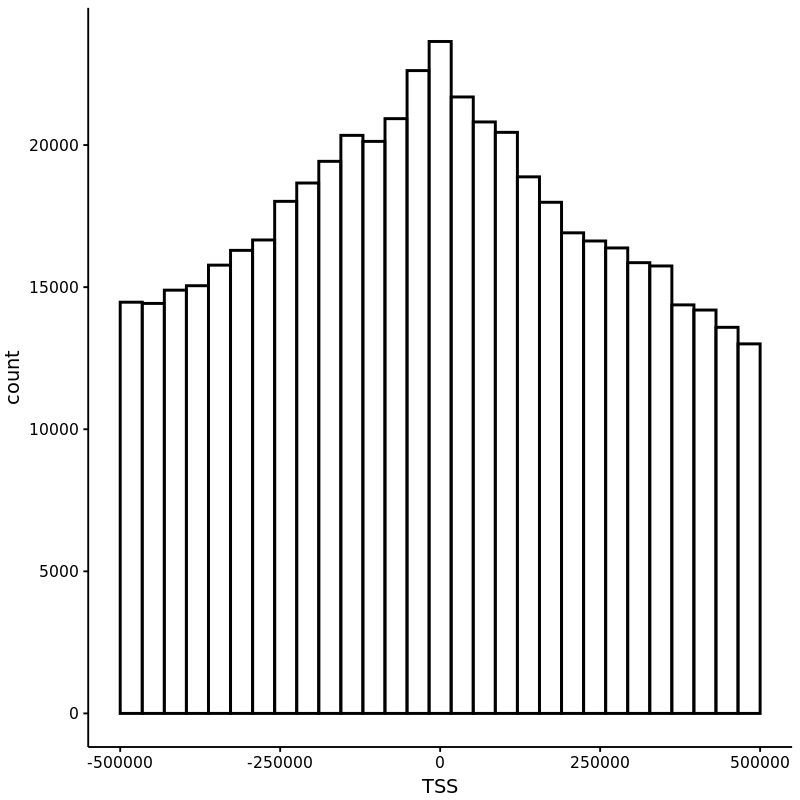

In [45]:
options(repr.plot.width = 4,repr.plot.height=4,repr.plot.res= 200)
temp %>% gghistogram(x="right",bins=30) + scale_x_continuous(limits = c(-500000,500000)) + xlab("TSS") + theme_Publication()

In [46]:
alldi <- read_tsv("../../figure3_related_new/di_emb_nonp//alldis.filtered.tsv.gz")

Rows: 694384 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"
Warning message:
"Removed 36716846 rows containing non-finite values (stat_bin)."


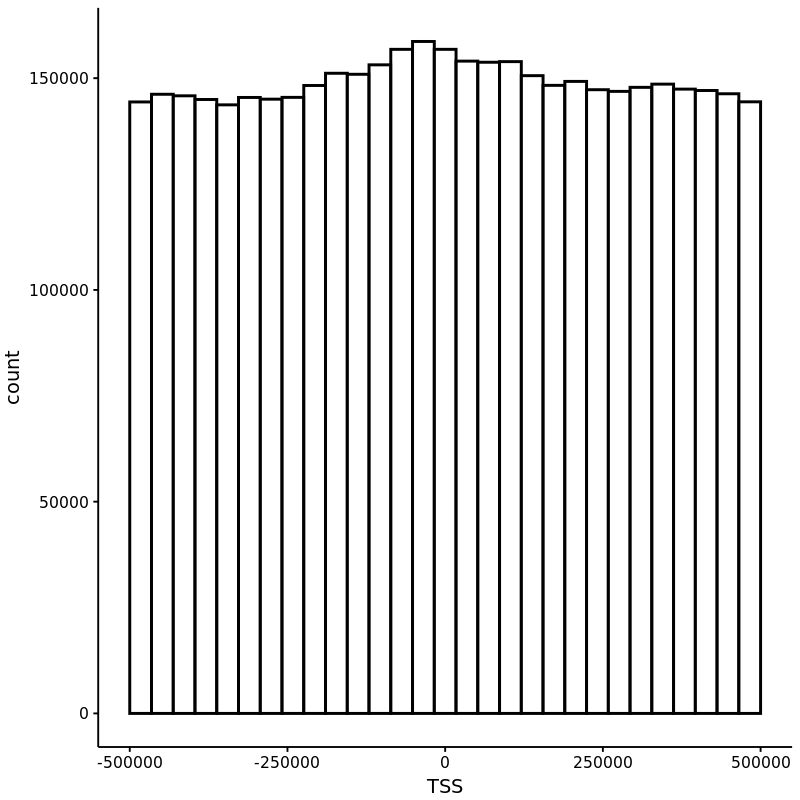

In [47]:
set.seed(42)
di_sample <- alldi %>% sample_n(100000) %>% mutate(logpv = -log10(pv))
di_sample <- rbind( di_sample %>% select(1:3,logpv) %>% mutate(start = start1,end=end1,chrom = chrom1) %>% select(chrom,start,end,logpv),
                    di_sample %>% select(1:3,logpv) %>% mutate(start = start1,end=end1,chrom = chrom1) %>% select(chrom,start,end,logpv))

tss %>% mutate(start = tss - 5e6,end = tss + 5e6,start = ifelse(start >0,start,0)) %>% select(chrom,start,end,name,tss,strand)%>% 
    valr::bed_intersect(di_sample) %>% mutate(TSS = tss.x - start.y - 10000)-> di_plotdata
di_plotdata %>% mutate(TSS=ifelse(strand.x == "+",TSS,-TSS)) -> di_plotdata
di_plotdata %>% gghistogram(x="TSS")+
    scale_x_continuous(limits = c(-500000,500000)) + xlab("TSS") + theme_Publication()

In [48]:
temp <- temp %>% rename(right = "TSS")
di_plotdata %>% select(TSS,logpv.y) %>% rename(logpv.y = "logpv") ->  di_plotdata

In [49]:
set.seed(42)
cutoff = 500000
plotdata <- rbind(temp %>% filter(abs(TSS) < cutoff) %>% mutate(type = "GADI"),di_plotdata  %>% filter(abs(TSS) < cutoff)%>% sample_n(dim(temp %>% filter(abs(TSS) < cutoff))[1]) %>% mutate(type = "DI"))

Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


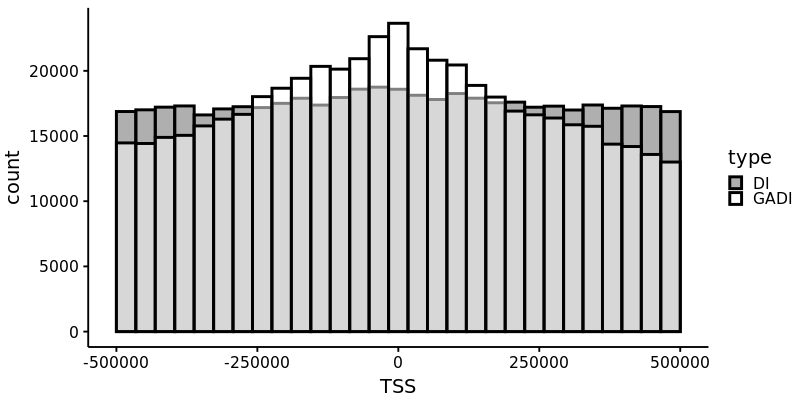

In [50]:
options(repr.plot.width = 4,repr.plot.height = 2,repr.plot.res = 200)
p <- plotdata %>% gghistogram(x="TSS",fill="type",palette = c("#606060","white"))+ theme_Publication() + 
    scale_x_continuous(limits = c(-cutoff,cutoff)) + theme(legend.position = "right",legend.direction = "vertical") 
p

In [51]:
p %>% ggsave(filename = "tssenrichment.pdf",height = 1, width =2,dpi=300,units ="in")

In [52]:
allgadi_bedpe %>% mutate(id=paste0("id",row_number())) %>% filter(pos == "chr7-18920000-19320000")

chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos,GADI_id,id
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr7,18910000,18930000,chr7,19310000,19330000,Fosb,0.4062433,0.0000001183391,0.000001081849,chr7-18920000-19320000,GADI_104382,id104382
chr7,18910000,18930000,chr7,19310000,19330000,Nectin2,0.3487156,0.0000071139965,0.000043143621,chr7-18920000-19320000,GADI_253977,id253977
chr7,18910000,18930000,chr7,19310000,19330000,Nova2,-0.3752617,0.0000011842563,0.000008614203,chr7-18920000-19320000,GADI_261077,id261077
